### Phys 629, Fall 2023, University of Mississippi


# Lecture 7, Chapter 3: Probability and Statistical Distributions

Material in this lecture and notebook is based upon the Basic Stats portion of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540), the Introduction to Probability & Statistics portion of A. Connolly's & Ž. Ivezić's "Astrostatistics & Machine Learning" class at the University of Washington (ASTR 598, https://github.com/dirac-institute/uw-astr598-w18), J. Bovy's mini-course on "Statistics & Inference in Astrophysics" at the University of Toronto (http://astro.utoronto.ca/~bovy/teaching.html), and Stephen R. Taylor (https://github.com/VanderbiltAstronomy/astr_8070_s22). 

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 3.

***Exercises required for class participation are in <font color='red'>red</font>.***

## Correlation coefficients <a class="anchor" id="three"></a>

We'd like to be able to quantify how well two samples of data are correlated with one another.

### Pearson's coefficient

Given two length-$N$ samples of data $\{x_i\}$ and $\{y_i\}$, Pearson's correlation coefficient is defined as

$$ r = \frac{\sum_{i=1}^N (x_i-\bar{x})(y_i-\bar{y})}{\sqrt{\sum_{i=1}^N (x_i-\bar{x})^2}\sqrt{\sum_{i=1}^N (y_i-\bar{y})^2}} $$

where $-1\leq r\leq 1$, and $r=0$ for uncorrelated variables.

If the pairs $(x_i,y_i)$ are drawn from uncorrelated univariate Gaussian distributions, then the distribution of $r$ follows a Student's $t$ distribution with $k=N-2$ degrees of freedom and $t = r\sqrt{(N-2)/(1-r^2)}$.

With this known "null hypothesis" distribution, a measured $r$ can be interpreted in terms of the significance with which we can reject the variables being correlated, e.g., if $N=10$ then the probability that a value of $r\geq 0.72$ arises just by chance noise fluctuations is $1\%$. 

There are two big problems with Pearson's coefficient though:
- It does not incorporate measurement uncertainties on the data.
- It is highly susceptible to outliers.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

rng = np.random.default_rng(seed=12)
X = np.linspace(-3, 3, 100)
Y = X

X = rng.uniform(0,10, size=10)
Y = rng.uniform(0,10, size=10)
rho = np.corrcoef(X, Y)
print(rho)

[[ 1.         -0.06749366]
 [-0.06749366  1.        ]]


### Spearman's coefficient

Similar definition to Pearson's, with sample values replaced by their cumulative ranks. As we've seen, cumulative statistics based on rank are more robust estimators than ones that use the actual sample values. The samples in each dataset are ranked from $1,\ldots,N$ in ascending order, with the largest value given the rank $N$. 

$$ r_S = \frac{\sum_{i=1}^N (R^x_i-\bar{R^x})(R^y_i-\bar{R^y})}{\sqrt{\sum_{i=1}^N (R^x_i-\bar{R^x})^2}\sqrt{\sum_{i=1}^N (R^y_i-\bar{R^y})^2}}. $$

The distribution of $r_S$ is the same as for Pearson's, except in the definition of the test statsitic $t$, $r$ is replaced by $r_S$.

### Kendall's coefficient

Kendall's coefficient uses the sample ranks, but does not take rank differences like in Spearman's coefficient. Instead, we compare the relative number of *concordant* and *discordant* pairs. 

**Concordant pairs** are where the differences in values between a pair of samples $j$ and $k$ have the same sign in $x$ and $y$, i.e., $(x_j-x_k)(y_j-y_k)>0$.

**Discordant pairs** are where the differences in values between a pair of samples $j$ and $k$ have the different signs in $x$ and $y$, i.e., $(x_j-x_k)(y_j-y_k)<0$.

*For perfectly correlated data, all $N(N-1)/2$ sample pairs will be concordant. For perfectly anti-correlated data, all pairs will be discordant.* 

Kendall's $\tau$ is then computed as

$$ \tau = 2\frac{N_c-N_d}{N(N-1)}.$$

In the following example that reproduces *Ivezic Fig. 3.24*, samples of $x$ and $y$ from a bivariate normal distribution with/without outlier contamination are assessed for correlation using each of the above. It is clear that Pearson's suffers considerably from outliers, while the rank-based coefficients are more resilient. 

@pickle_results: using precomputed results from 'fig_correlations_dump.pkl'


/Users/arindam/miniconda3/envs/phys629/lib/python3.8/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


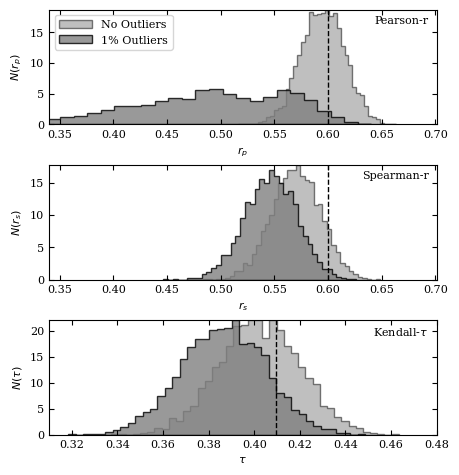

In [2]:
%run ../../lectures/scripts/fig_correlations.py

## Sampling from arbitrary distributions <a class="anchor" id="four"></a>

Numerical simulations of the measurment process are often the only practical way to assess the complicated influences of selection effects, biases, and other processing stages of data taking. Such approaches are often called **Monte Carlo simulations**, producing **Monte Carlo or mock samples**. It is often highly beneficial to resample from arbitrary distributions in order to simulate further measurements.

Imagine you've got an arbitrary distribution $h(x)$ in analytic or histogram form (or alternatively just samples from it). How do you make more samples if it's not one of the standard distributions in `numpy` or `scipy`? We'll discuss the 1D case here in two ways. **Rejection sampling** (less preferred) and **Inverse transform sampling** (highly preferred and easy).

Let's generate some data using the mix of Cauchy distributions that we've employed several times.

<font color='red'>Execute this cell</font>

In [3]:
import scipy
import numpy as np
import matplotlib.pyplot as plt 
# Let's generate some data: a mix of several Cauchy distributions
random_state = np.random.RandomState(seed=0)
N = 10000
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
data = np.concatenate([scipy.stats.cauchy(mu, gamma).rvs(int(f * N), random_state=random_state) for (mu, gamma, f) in mu_gamma_f])
data = data[data > -10]
data = data[data < 30]

<font color='red'>Make a numpy histogram object out of the data with `density=True` and `bins=50`. This will return a tuple of bin heights and bin edges.</font>

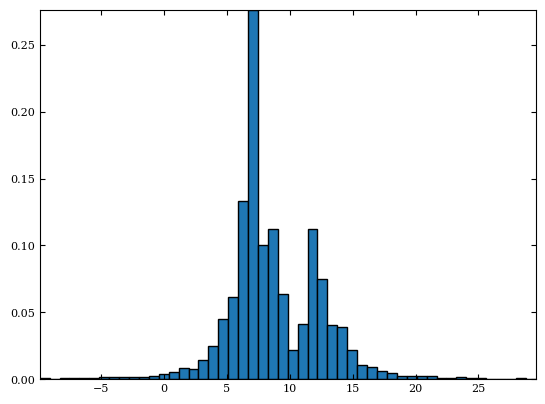

In [4]:
countsC, bin_edgesC, _ = plt.hist(data, bins=50, density=True)

### Rejection sampling

The process for sampling from an arbitrary distribution with rejection is:

1) Decide on a straightforward *proposal distribution* $q(x)$ to propose new samples. It should be wide enough to capture the tails of $h(x)$. We'll use a uniform distribution here.

2) Generate a random sample from $q(x)$, $x_i$.

3) Now generate a random sample, $u$, from a uniform distribution in the range $[0,\mathrm{max}(h(x))]$, where the upper bound should be as large or larger than the maximum density of $h(x)$. (This could be worked out analytically or by histograming the data.)

4) If $u\leq h(x_i)$ accept the point, or else reject it and try again from step 2.


This is shown pictorally here (image reproduced by [Robert Collins class CSE586 "Computer Vision II" at PSU](http://www.cse.psu.edu/~rtc12/CSE586/))

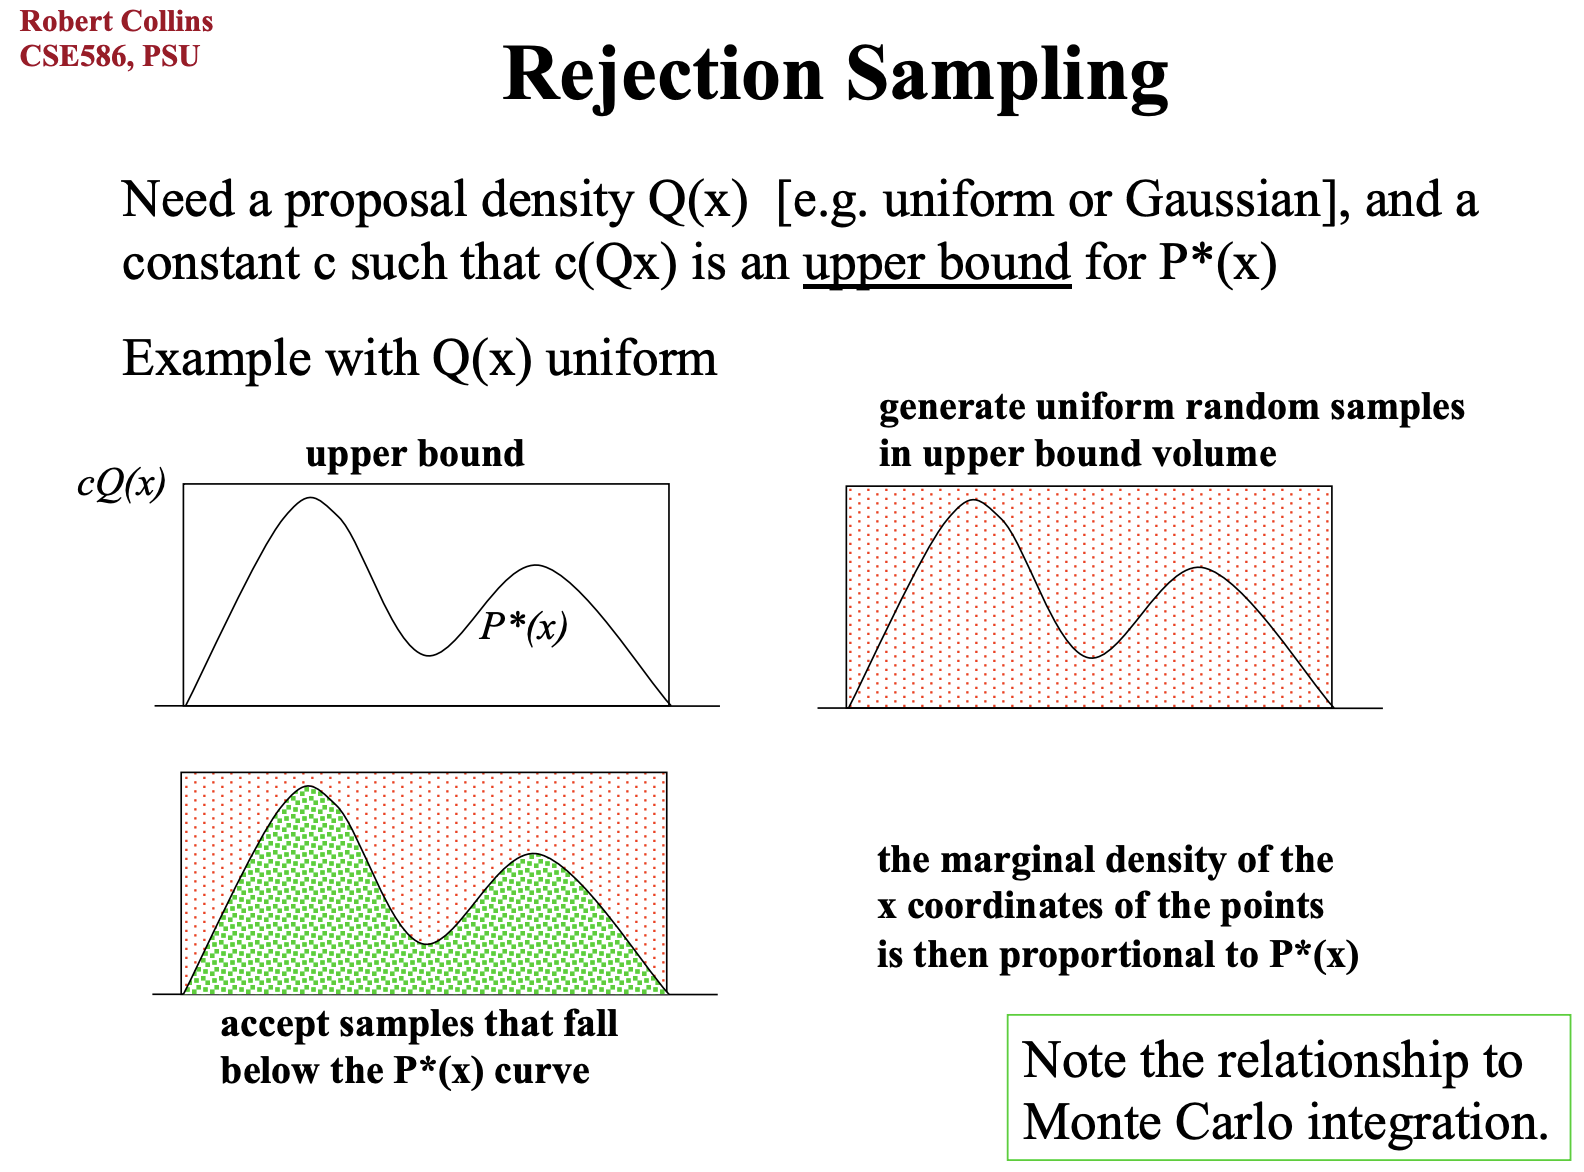

Let's try this for a simple Gaussian.

<font color='red'>Execute this cell</font>

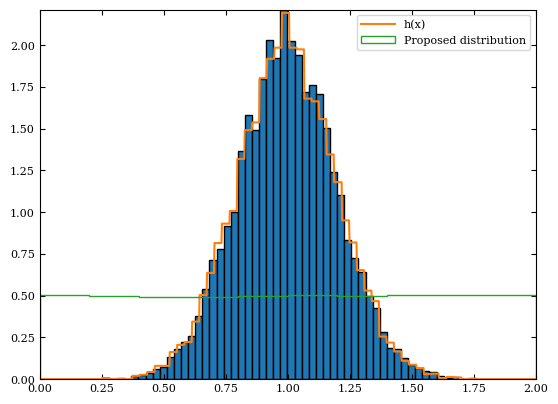

In [5]:
# make some sample data
sample_data = np.random.normal(1.0,0.2,10000)

# make a simple histogram object
counts, bins = np.histogram(sample_data, bins=50, density=True)
maxh = counts.max() # find the maximum

# Make a scipy.stats random variable object from a histogram
# This is a great hack!
disth = scipy.stats.rv_histogram((counts,bins))

N = 100000 # trials
q = np.random.uniform(0.0, 2.0, N) # proposed points
u = np.random.uniform(0, maxh, N) # uniform draws

mask = u<=disth.pdf(q) # assess whether u <= q(x_i) in the smart pythonic way

monte_carlo = q[mask] # reject all points that don't pass, using masking

plt.hist(monte_carlo, bins=50, density=True);

# My addition
xgrid = np.linspace(0., 2., 1000)
y = disth.pdf(xgrid)
plt.plot(xgrid, y, label = 'h(x)')
plt.hist(q, histtype = 'step', density=True, label= 'Proposed distribution')
plt.legend()



...of course once you have the `disth` you can immediately draw from the pdf using `disth.rvs()`. This is worth knowing for your own research. It's a great hack, but it's important to know the theory behind all this.

<font color='red'>Use this process to generate at least $1000$ new samples of the Cauchy-mix (i.e., the `data` sample), and make a plot that shows histograms of the original data and the new Monte Carlo samples to compare.</font>

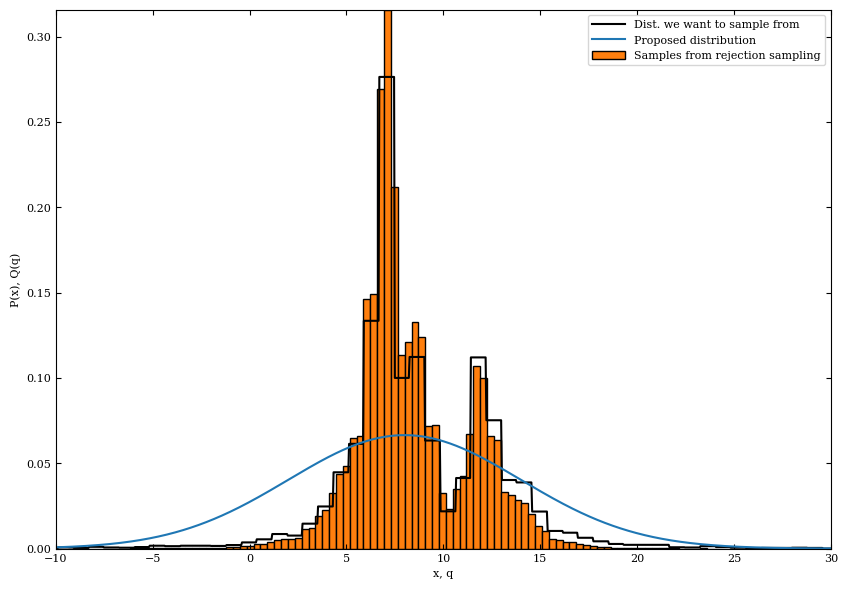

In [6]:
#random variable object for the distribution we want to sample from
disth = scipy.stats.rv_histogram((countsC, bin_edgesC)) 
hmax = countsC.max()

N = 10**6
rng = np.random.default_rng(seed=10)

#proposed distribution, a gaussian

def gauss(x, mu, sigma):
    pi=np.pi
    f = 1/(np.sqrt(2*pi*sigma**2)) * np.exp(-(x - mu)**2/(2*sigma**2))
    return f

mu = 8
sigma=6
q = rng.normal(mu, sigma, size=N) 

#Uniform draws
u = rng.uniform(0, hmax, size=N) 

mask = u<=disth.pdf(q)

new_samples = q[mask]

#Plotting
xgrid = np.linspace(-10, 30, 1000)

fig, ax = plt.subplots()
fig.set_size_inches(10,7)
ax.set_xlabel('x, q')
ax.set_ylabel('P(x), Q(q)')
#ax.set_ylim(0, 0.05)

ax.plot(xgrid, disth.pdf(xgrid), c='black', label='Dist. we want to sample from')
ax.plot(xgrid, gauss(xgrid, mu, sigma), label='Proposed distribution')
#ax.hist(q, bins=100, histtype='step', density=True, label='Proposed distribution')
ax.hist(new_samples, bins=100, density=True, label='Samples from rejection sampling')
ax.legend()


## Importance sampling test

I suggested after class that I might be able to modify importance sampling to sample from an unkown distribution instead of using it for calculating expectation values or integration.  

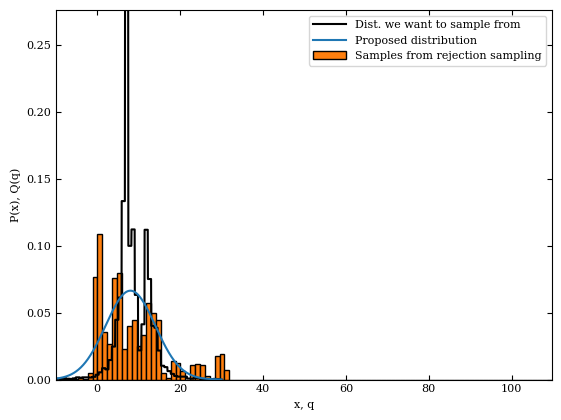

In [7]:
#Code to check the hypothesis

N = 10**6
q = rng.normal(mu, sigma, size=N) 
xx = q * ( disth.pdf(q) / gauss(q, mu, sigma))

xgrid = np.linspace(-10, 30, 1000)
fig, ax = plt.subplots()
#fig.set_size_inches(10,7)
ax.set_xlabel('x, q')
ax.set_ylabel('P(x), Q(q)')
#ax.set_ylim(0, 0.05)

ax.plot(xgrid, disth.pdf(xgrid), c='black', label='Dist. we want to sample from')
ax.plot(xgrid, gauss(xgrid, mu, sigma), label='Proposed distribution')
#ax.hist(q, bins=100, histtype='step', density=True, label='Proposed distribution')
ax.hist(xx, bins=100, density=True, label='Samples from rejection sampling')
ax.legend()



From the above plot, it can be clearly seen that my idea of importance sampling doesn't work

### Inverse transform sampling

Rejection sampling works, but wouldn't it be awesome if we didn't have to discard *any* points during our sampling? This is the power and simplicity of **inverse transform sampling**. The process is exceedingly simple. 

1) To sample from an arbitrary $h(x)$, you will also need the cdf $H(x)$ and its inverse, the quantile function $H^{-1}(x)$. If $h(x)$ is difficult to integrate, or $H(x)$ is difficult to invert to get the quantile function, then you could use numerical techniques to interpolate or produce lookup tables.

2) Generate a random sample $u$ from a uniform random distribution $[0,1]$. 

3) Using the quantile function $H^{-1}(x)$, find the value of $x$ below which a fraction $u$ of the distribution is contained. 

4) The $x$ value you get is a random sample from $h(x)$. Easy, right?

Let's try with the Gaussian again.

<font color='red'>Execute this cell</font>

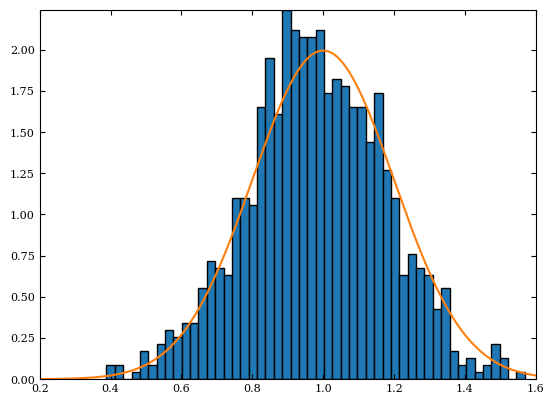

In [8]:
# make some sample data
sample_data = np.random.normal(1.0,0.2,10000)

# make a simple histogram object
counts, bins = np.histogram(sample_data, bins=50, density=True)
bin_mids = (bins[1:] + bins[:-1]) / 2 # mid location of bins
 
simple_cdf = np.cumsum(counts) / np.sum(counts) # very simply cumulative sum

# set up an interpolation of the inverse cumulative distribution
tck = scipy.interpolate.interp1d(simple_cdf, bin_mids)

# sample evenly along the cumulative distribution, and interpolate
# little hack to make sure no points are generated outside interpolation range.
# not ideal
u = np.random.uniform(0.001, 0.999, 1000) 
x_sample = tck(u)

plt.hist(x_sample, bins=50, density=True);

#My addition
xgrid = np.linspace(0.2,1.6,1000)

plt.plot(xgrid, gauss(xgrid, 1, 0.2))

<font color='red'>Use this process to generate exactly $1000$ new samples of the Cauchy-mix (i.e. the `data` sample), and make a plot that shows histograms of the original data and the new Monte Carlo samples to compare.</font>

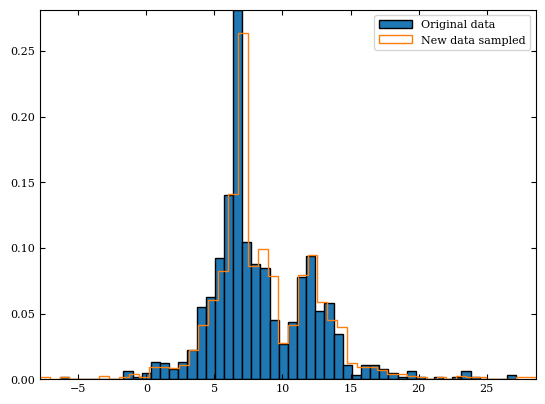

In [9]:
N = 10**3
new_data = disth.rvs(size=N)

# make a simple histogram object
counts, bins = np.histogram(new_data, bins=50, density=True)
bin_mids = (bins[1:] + bins[:-1]) / 2 # mid location of bins
 
simple_cdf = np.cumsum(counts) / np.sum(counts) # very simply cumulative sum

# set up an interpolation of the inverse cumulative distribution
tck = scipy.interpolate.interp1d(simple_cdf, bin_mids)

# sample evenly along the cumulative distribution, and interpolate
# libttle hack to make sure no points are generated outside interpolation range.
# not ideal

rng = np.random.default_rng(seed=10)
u = rng.uniform(0.001, 0.999, 1000) 
x_sample = tck(u)

plt.hist(x_sample, bins=50, density=True, label='Original data');
plt.hist(new_data, bins=50, density=True, histtype='step', label='New data sampled');
plt.legend()

Run the script below and then load up the code in the cell after to see how easily `AstroML` let's you do all this.

/Users/arindam/Documents/Grad_school/phys629/phys629-fall-2023/lectures/scripts/fig_clone_distribution.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  x = np.hstack((d.rvs(int(f * Ndata)) for d, f in zip(dists, fracs)))


KS test: D = 0.0028; p = 1


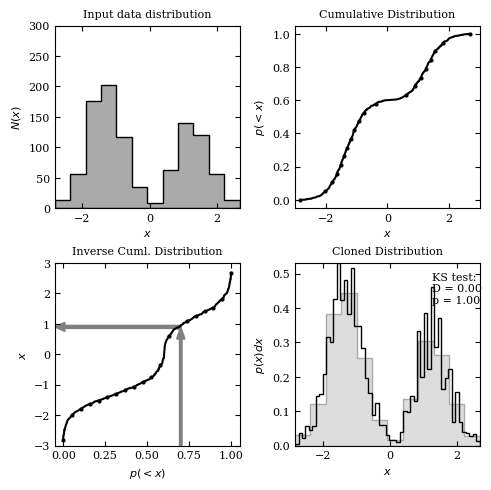

In [10]:
%run ../../lectures/scripts/fig_clone_distribution.py

/var/folders/07/hx4mppj112j6221rbs_3cbhw0000gn/T/ipykernel_8551/2942568193.py:57: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  x = np.hstack((d.rvs(int(f * Ndata)) for d, f in zip(dists, fracs)))


KS test: D = 0.0028; p = 1


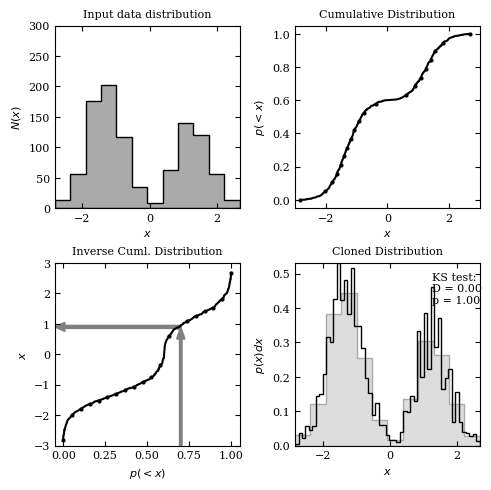

In [11]:
# %load ./scripts/fig_clone_distribution.py
r"""
Random Values from an Empirical Distribution
--------------------------------------------
Figure 3.25.

A demonstration of how to empirically clone a distribution, using a spline
interpolation to approximate the inverse of the observed cumulative
distribution. This allows us to nonparametrically select new random samples
approximating an observed distribution. First the list of points is sorted,
and the rank of each point is used to approximate the cumulative distribution
(upper right). Flipping the axes gives the inverse cumulative distribution on
a regular grid (lower left). After performing a cubic spline fit to the inverse
distribution, a uniformly sampled x value maps to a y value which approximates
the observed pdf. The lower-right panel shows the result. The K-S test
(see section 4.7.2) indicates that the samples are consistent with being
drawn from the same distribution. This method, while fast and effective,
cannot be easily extended to multiple dimensions.

This example uses the routine
:class:`astroML.density_estimation.EmpiricalDistribution`
to clone the distribution
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
from scipy import stats, interpolate
from astropy.visualization import hist
from astroML.density_estimation import EmpiricalDistribution

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Create a distribution and clone it
Ndata = 1000
Nclone = 100000
np.random.seed(0)

# generate an 'observed' bimodal distribution with 10000 values
dists = (stats.norm(-1.3, 0.5), stats.norm(1.3, 0.5))
fracs = (0.6, 0.4)
x = np.hstack((d.rvs(int(f * Ndata)) for d, f in zip(dists, fracs)))

# We can clone the distribution easily with this function
x_cloned = EmpiricalDistribution(x).rvs(Nclone)

# compute the KS test to check if they're the same
D, p = stats.ks_2samp(x, x_cloned)
print("KS test: D = %.2g; p = %.2g" % (D, p))

#------------------------------------------------------------
# For the sake of this example, we need to calculate some
#  of the partial steps used by EmpiricalDistribution

# create a cumulative distribution
x.sort()
Px_cuml = np.linspace(0, 1, Ndata)

# set up an interpolation of the inverse cumulative distribution
tck = interpolate.splrep(Px_cuml, x)

# sample evenly along the cumulative distribution, and interpolate
Px_cuml_sample = np.linspace(0, 1, 10 * Ndata)
x_sample = interpolate.splev(Px_cuml_sample, tck)

#------------------------------------------------------------
# Plot the cloned distribution and the procedure for obtaining it
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0.3, left=0.1, right=0.95,
                    bottom=0.08, top=0.92, wspace=0.3)

indices = np.linspace(0, Ndata - 1, 20).astype(int)

# plot a histogram of the input
ax = fig.add_subplot(221)
hist(x, bins='knuth', ax=ax,
     histtype='stepfilled', ec='k', fc='#AAAAAA')
ax.set_ylim(0, 300)
ax.set_title('Input data distribution')
ax.set_xlabel('$x$')
ax.set_ylabel('$N(x)$')

# plot the cumulative distribution
ax = fig.add_subplot(222)
ax.scatter(x[indices], Px_cuml[indices], lw=0, c='k', s=9)
ax.plot(x, Px_cuml, '-k')
ax.set_xlim(-3, 3)
ax.set_ylim(-0.05, 1.05)
ax.set_title('Cumulative Distribution')
ax.set_xlabel('$x$')
ax.set_ylabel('$p(<x)$')

# plot the inverse cumulative distribution and spline fit
ax = fig.add_subplot(223)
ax.scatter(Px_cuml[indices], x[indices], lw=0, c='k', s=9)
ax.plot(Px_cuml_sample, x_sample, '-k')
ax.arrow(0.7, -3, 0, 3.5, width=0.015, fc='gray', ec='gray',
         head_width=0.05, head_length=0.4)
ax.arrow(0.7, 0.9, -0.69, 0, width=0.1, fc='gray', ec='gray',
         head_width=0.3, head_length=0.06)
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-3, 3)
ax.set_title('Inverse Cuml. Distribution')
ax.set_xlabel('$p(<x)$')
ax.set_ylabel('$x$')

# plot the resulting cloned distribution
ax = fig.add_subplot(224)
hist(x, bins='knuth', ax=ax,
     histtype='stepfilled', density=True,
     ec='#AAAAAA', fc='#DDDDDD',
     label='input data')
hist(x_cloned, bins='knuth', ax=ax,
     histtype='step', density=True,
     color='k', label='cloned data')
ax.set_title('Cloned Distribution')
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)dx$')
ax.text(0.74, 0.95, "KS test:\nD = %.2f\np = %.2f" % (D, p),
        ha='left', va='top', transform=ax.transAxes)

plt.show()